In [14]:
import numpy as np
import scipy.io
import deepxde as dde

# For plotting
import matplotlib.pyplot as plt
from scipy.interpolate import griddata


In [3]:
# In[2]:


data = scipy.io.loadmat("Data/NLSG_modify_2.mat")

x = data["x"]               # shape: (256, 1)
t = data["t"].flatten()     # shape: (100,1)
u = data["usol2"]               # shape: (256, 100), complex-valued

# 若不是复数类型但以实部+虚部分开提供，请改为：
# u = data["u_real"] + 1j * data["u_imag"]

# 2. 提取实部和虚部
u_real = np.real(u)
u_imag = np.imag(u)


# 2. 提取初始条件 t=0

X_init = np.hstack((x, np.full_like(x, t[0])))    # (256, 2)
Y_init_u = u_real[:, 0:1]                         # (256, 1)
Y_init_v = u_imag[:, 0:1]

# 3. 定义几何区域
space_domain = dde.geometry.Interval(x.min(), x.max())
time_domain = dde.geometry.TimeDomain(t[0], t[-1])
geomtime = dde.geometry.GeometryXTime(space_domain, time_domain)

t_idx1 = 199
idx = np.random.choice(x.shape[0], 400, replace=False)
x_subset = x[idx]
u_real_subset1 = u_real[idx, t_idx1:t_idx1+1]
u_imag_subset1 = u_imag[idx, t_idx1:t_idx1+1]
u_real_subset2 = u_real[idx, t_idx2:t_idx2+1]
u_imag_subset2 = u_imag[idx, t_idx2:t_idx2+1]

X_obs1 = np.hstack((x_subset, np.full_like(x_subset, t[t_idx1])))
Y_obs1 = np.hstack((u_real_subset1, u_imag_subset1))

observe_real1 = dde.PointSetBC(X_obs1, Y_obs1[:, 0:1], component=0)
observe_imag1 = dde.PointSetBC(X_obs1, Y_obs1[:, 1:2], component=1)

t_idx2 = 399
X_obs2 = np.hstack((x_subset, np.full_like(x_subset, t[t_idx2])))
Y_obs2 = np.hstack((u_real_subset2, u_imag_subset2))

observe_real2 = dde.PointSetBC(X_obs2, Y_obs2[:, 0:1], component=0)
observe_imag2 = dde.PointSetBC(X_obs2, Y_obs2[:, 1:2], component=1)



NameError: name 'scipy' is not defined

In [16]:
def pde(x, y):
    """
    INPUTS:
        x: x[:,0] is x-coordinate
           x[:,1] is t-coordinate
        y: Network output, in this case:
            y[:,0] is u(x,t) the real part
            y[:,1] is v(x,t) the imaginary part
    OUTPUT:
        The pde in standard form i.e. something that must be zero
    """

    u = y[:, 0:1]
    v = y[:, 1:2]

    # In 'jacobian', i is the output component and j is the input component
    u_t = dde.grad.jacobian(y, x, i=0, j=1)
    v_t = dde.grad.jacobian(y, x, i=1, j=1)

    u_x = dde.grad.jacobian(y, x, i=0, j=0)
    v_x = dde.grad.jacobian(y, x, i=1, j=0)

    # In 'hessian', i and j are both input components. (The Hessian could be in principle something like d^2y/dxdt, d^2y/d^2x etc)
    # The output component is selected by "component"
    u_xx = dde.grad.hessian(y, x, component=0, i=0, j=0)
    v_xx = dde.grad.hessian(y, x, component=1, i=0, j=0)

    f_u = u_t + 0.5 * v_xx + (u ** 2 + v ** 2) * v
    f_v = v_t - 0.5 * u_xx - (u ** 2 + v ** 2) * u

    return [f_u, f_v]







In [2]:
t(t_idx1)

NameError: name 't' is not defined

In [10]:
# Boundary and Initial conditions

# Periodic Boundary conditions
bc_u_0 = dde.PeriodicBC(
    geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=0, component=0
)
bc_u_1 = dde.PeriodicBC(
    geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=1, component=0
)
bc_v_0 = dde.PeriodicBC(
    geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=0, component=1
)
bc_v_1 = dde.PeriodicBC(
    geomtime, 0, lambda _, on_boundary: on_boundary, derivative_order=1, component=1
)



ic_u = dde.PointSetBC(X_init, Y_init_u, component=0)
ic_v = dde.PointSetBC(X_init, Y_init_v, component=1)




data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc_u_0, bc_u_1, bc_v_0, bc_v_1, ic_u, ic_v, observe_real1, observe_imag1,observe_real2, observe_imag2],
    num_domain=10000,
    num_boundary=400,
    num_initial=400,
    train_distribution="pseudo",
)


In [17]:

def boundary_func_u_real(x):
    return u_real[0, :]  # 取 x=0 时的实部作为边界值

def boundary_func_u_imag(x):
    return u_imag[0, :]  # 取 x=0 时的虚部作为边界值

def boundary_func_v_real(x):
    return u_real[-1, :]  # 取 x=1 时的实部作为边界值

def boundary_func_v_imag(x):
    return u_imag[-1, :]  # 取 x=1 时的虚部作为边界值

# 设置边界条件
bc_u_real = dde.DirichletBC(geomtime, boundary_func_u_real, lambda x, on_boundary: on_boundary, component=0)
bc_u_imag = dde.DirichletBC(geomtime, boundary_func_u_imag, lambda x, on_boundary: on_boundary, component=1)

bc_v_real = dde.DirichletBC(geomtime, boundary_func_v_real, lambda x, on_boundary: on_boundary, component=0)
bc_v_imag = dde.DirichletBC(geomtime, boundary_func_v_imag, lambda x, on_boundary: on_boundary, component=1)

ic_u = dde.PointSetBC(X_init, Y_init_u, component=0)
ic_v = dde.PointSetBC(X_init, Y_init_v, component=1)


# 训练数据
data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc_u_real, bc_u_imag, bc_v_real, bc_v_imag, ic_u, ic_v, observe_real1, observe_imag1,observe_real2, observe_imag2],
    num_domain=10000,
    num_boundary=400,
    num_initial=200,
    train_distribution="pseudo",
)


In [18]:


# Network architecture
net = dde.nn.FNN([2] + [100] * 6 + [2], "tanh", "Glorot normal")

model = dde.Model(data, net)



model.compile("adam", lr=1e-3, loss="MSE")
model.train(iterations=40000, display_every=1000)


# L-BFGS optimization.

# In[8]:


dde.optimizers.config.set_LBFGS_options(
    maxcor=50,
    ftol=1.0 * np.finfo(float).eps,
    gtol=1e-08,
    maxiter=10000,
    maxfun=10000,
    maxls=50,
)
model.compile("L-BFGS")
model.train()


Compiling model...
Building feed-forward neural network...
'build' took 0.082472 s



2025-05-11 14:13:46.586538: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22028 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:3d:00.0, compute capability: 8.9


'compile' took 1.120956 s

Training model...

Step      Train loss                                                                                                                  Test loss                                                                                                                   Test metric
0         [4.91e-03, 1.33e-02, 7.38e-01, 4.39e-01, 7.38e-01, 4.39e-01, 7.05e-01, 5.39e-01, 9.66e-01, 4.25e-03, 1.50e+00, 6.59e-01]    [4.91e-03, 1.33e-02, 7.38e-01, 4.39e-01, 7.38e-01, 4.39e-01, 7.05e-01, 5.39e-01, 9.66e-01, 4.25e-03, 1.50e+00, 6.59e-01]    []  
1000      [1.39e-01, 8.43e-02, 5.30e-01, 4.46e-01, 5.30e-01, 4.46e-01, 1.20e-02, 1.45e-02, 1.05e-01, 3.82e-04, 1.87e-02, 2.02e-02]    [1.39e-01, 8.43e-02, 5.30e-01, 4.46e-01, 5.30e-01, 4.46e-01, 1.20e-02, 1.45e-02, 1.05e-01, 3.82e-04, 1.87e-02, 2.02e-02]    []  
2000      [6.60e-02, 5.71e-02, 5.28e-01, 4.41e-01, 5.28e-01, 4.41e-01, 4.77e-03, 8.79e-03, 4.93e-02, 2.55e-04, 6.55e-03, 9.98e-03]    [6.60e-02, 5.71e-02, 5.2

KeyboardInterrupt: 

In [19]:
# Make prediction
X, T = np.meshgrid(x, t, indexing='ij')  # X, T: (256, 100)
X_star = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))
prediction = model.predict(X_star)

u_pred = prediction[:, 0]  # 实部预测
v_pred = prediction[:, 1]  # 虚部预测

from scipy.io import savemat
savemat('NLS_pred2.mat', {'u': u_pred, 'v':v_pred})



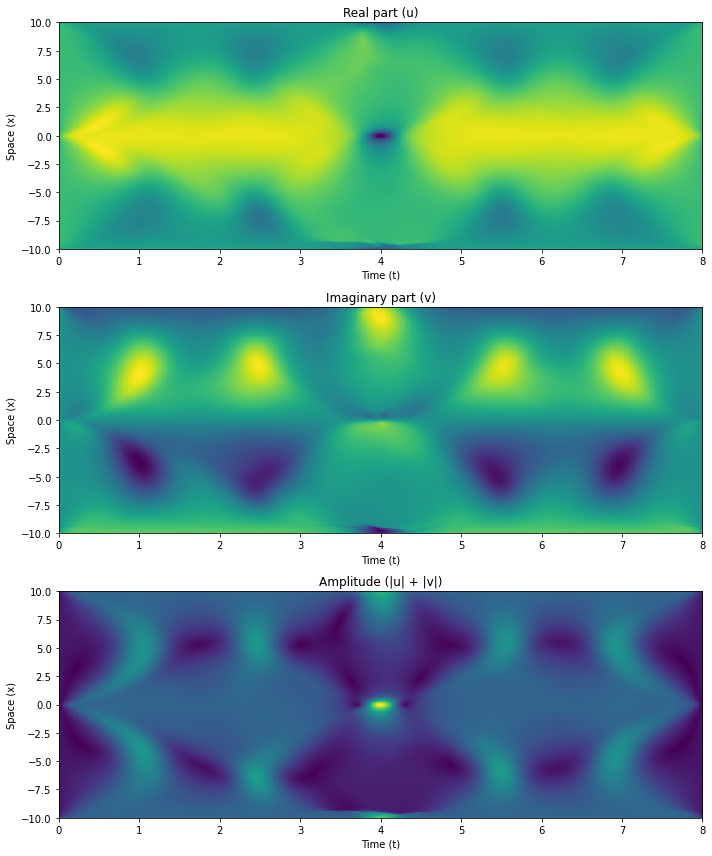

In [20]:
# 插值至完整网格
X, T = np.meshgrid(x, t, indexing='ij')  # X, T: (256, 100)
u_grid = griddata(X_star, u_pred, (X, T), method="cubic")
v_grid = griddata(X_star, v_pred, (X, T), method="cubic")

# 计算幅度
h = np.sqrt(u_grid ** 2 + v_grid ** 2)

# 绘制预测结果
fig, ax = plt.subplots(3, 1, figsize=(10, 12))

ax[0].imshow(
    u_grid.T,
    interpolation="nearest",
    cmap="viridis",
    extent=[t.min(), t.max(), x.min(), x.max()],
    origin="lower",
    aspect="auto",
)
ax[0].set_title("Real part (u)")
ax[0].set_xlabel("Time (t)")
ax[0].set_ylabel("Space (x)")
# ax[0].colorbar(label="u")

ax[1].imshow(
    v_grid.T,
    interpolation="nearest",
    cmap="viridis",
    extent=[t.min(), t.max(), x.min(), x.max()],
    origin="lower",
    aspect="auto",
)
ax[1].set_title("Imaginary part (v)")
ax[1].set_xlabel("Time (t)")
ax[1].set_ylabel("Space (x)")
# ax[1].colorbar(label="v")

ax[2].imshow(
    h.T,
    interpolation="nearest",
    cmap="viridis",
    extent=[t.min(), t.max(), x.min(), x.max()],
    origin="lower",
    aspect="auto",
)
ax[2].set_title("Amplitude (|u| + |v|)")
ax[2].set_xlabel("Time (t)")
ax[2].set_ylabel("Space (x)")
# ax[2].colorbar(label="Amplitude")

plt.tight_layout()
plt.show()